In [3]:
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import pandas as pd

from utils.create_connection_db import *

import warnings
warnings.filterwarnings("ignore")

In [5]:
#Criando a conexão com o banco de dados criado
conn = create_connection("../database/microdata_enem_2023.db")

In [6]:
#Selecionando apenas os dados de estudantes maranhenses e com nota não nula na redação
query = open("../scripts_sql/refined_data_query.sql", "r").read()
df = pd.read_sql(query, conn)

In [7]:
#Descartando as variáveis não importantes para o problema:
variaveis_nao_importantes = [
    "NO_MUNICIPIO_ESC",
    "NO_MUNICIPIO_PROVA",
    "SG_UF_ESC",
    "SG_UF_PROVA",
    "TP_PRESENCA_CN",
    "TP_PRESENCA_CH",
    "TP_PRESENCA_LC",
    "TP_PRESENCA_MT",
    "CO_PROVA_CN",
    "CO_PROVA_CH",
    "CO_PROVA_LC",
    "CO_PROVA_MT",
    "TP_LINGUA",
    "TP_STATUS_REDACAO",
    "NU_NOTA_COMP1",
    "NU_NOTA_COMP2",
    "NU_NOTA_COMP3",
    "NU_NOTA_COMP4",
    "NU_NOTA_COMP5"
]

In [5]:
#Selecionando as variáveis numéricas para tratamento diferente das colunas restantes
variaveis_numericas = [
    "NU_NOTA_CN",
    "NU_NOTA_CH",
    "NU_NOTA_LC",
    "NU_NOTA_MT",
    "NU_NOTA_REDACAO"
]

In [6]:
#Utilizando apendas as variáveis categóricas relacionados a dados da escola ou dados demográficos
variaveis_categoricas = [coluna for coluna in df.columns if (coluna not in variaveis_nao_importantes) and (coluna not in variaveis_numericas)]

In [7]:
#Transformando as colunas para o seu tipo original
for coluna in variaveis_categoricas:
    df[coluna] = df[coluna].astype('category')

for coluna in variaveis_numericas:
    df[coluna] = df[coluna].astype(float)

In [8]:
#Pegando apenas as colunas necessárias para a criação do modelo
df = df[variaveis_categoricas + variaveis_numericas].reset_index(drop=True)

In [9]:
#Removendo todos os registros que contem ao menos um valor nulo
df = df.dropna()

In [12]:
#Removendo todas as redações zeradas (Ainda em observação...)
df = df.loc[df.NU_NOTA_REDACAO > 0, :]

Testes, Visualizações e Transformações

1. Transformar o target utilizando box-cox traz uma grande diferença?

In [14]:
fitted_data, fitted_lambda = stats.boxcox(df["NU_NOTA_REDACAO"])

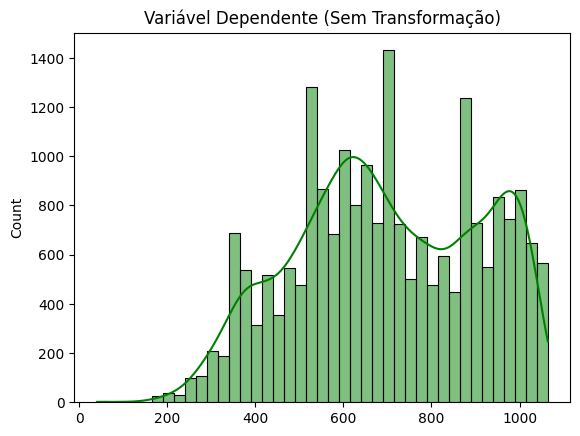

In [18]:
plt.title("Variável Dependente (Sem Transformação)")
sns.histplot(fitted_data, kde=True, label = "Non-Normal", color ="green")
plt.show()

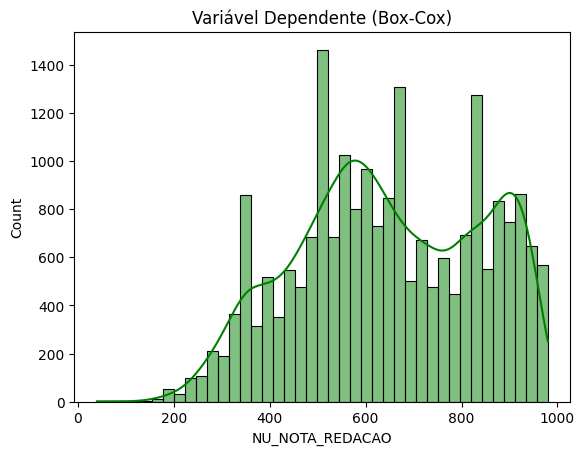

In [17]:
plt.title("Variável Dependente (Box-Cox)")
sns.histplot(df["NU_NOTA_REDACAO"], kde=True, label = "Normal*", color ="green")
plt.show()

Não houve uma mudança significativa após a transformação

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
import numpy as np
from numpy import absolute

In [27]:
X = pd.get_dummies(df.drop(columns=['NU_NOTA_REDACAO'], errors="ignore"), drop_first=True)
y = df["NU_NOTA_REDACAO"]

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [29]:
model = GradientBoostingRegressor()

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(model, X, y, scoring="neg_mean_absolute_error", cv=cv, n_jobs=-1)
scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Mean MAE: 111.930 (1.971)


In [30]:
model.fit(X_train, y_train)

GradientBoostingRegressor()

In [32]:
y_pred = model.predict(X_test)

In [54]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

# Função para calcular as métricas de avaliação
def print_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    
    print(45*"-")
    print(f"MAE (Mean Absolute Error): {mae:.4f}")
    print(f"MSE (Mean Squared Error): {mse:.4f}")
    print(f"RMSE (Root Mean Squared Error): {rmse:.4f}")
    print(f"R² (Coeficiente de Determinação): {r2:.4f}")
    print(45*"-")

In [55]:
print_metrics(y_test, y_pred)

---------------------------------------------
MAE (Mean Absolute Error): 111.8885
MSE (Mean Squared Error): 19858.2726
RMSE (Root Mean Squared Error): 140.9194
R² (Coeficiente de Determinação): 0.4542
---------------------------------------------
